In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from power_spectrum_utils import power_spectrum_np_2d
from wgan_utils import define_test, check_coords

from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
random.seed(1)

In [2]:
mean_5=14280.155
std_5=89914.586
max_5=47676240

mean_5b=15612.119010841609

In [2]:
def get_samples(file, s_sample, nsamples, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-s_sample
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, sample_coords)
        
        sample_list.append(sample_coords)
    
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    #f file has to be opened outisde the function
    
    for c in sample_list:
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        #Modify here for 2D or 3D
        sample_array.append(np.array(a))
    
    return np.array(sample_array)

def build_df(n_samples):
    col_list = ['mean', 'std', 'max', 'pk_mean', 'pk_std', 'pk_range', 'below_mean', 'kurtosis',
                'skew','q25', 'q50', 'q75', 'total', 'min']
    df = pd.DataFrame(index=list(range(n_samples)), columns=col_list)
    no_pixels = s_sample**3
    
    #2D
    for n in range(n_samples):
        arr=get_samples(0, s_sample, 1, tc)
        arr = arr[0].mean(axis=2)
        
        k, Pk = power_spectrum_np_2d(arr, mean_5, (75.0/2048.0)*s_sample)
        
        row = {'mean': arr.mean(), 'std': arr.std(), 'max': np.amax(arr), 
               'pk_mean': Pk.mean(), 'pk_std': Pk.std()  , 'pk_range': Pk[0]-Pk[-1] ,
               'below_mean' : (arr< mean_5).sum() / no_pixels, 'kurtosis': kurtosis(arr, axis=None),
               'skew': kurtosis(arr, axis=None),
              'q25' : np.percentile(arr, 25), 'q50' : np.percentile(arr, 50), 'q75' : np.percentile(arr, 75),
              'total': np.sum(arr), 'min': min(arr)}
               #'above_std' : 1 - ((arr [n]< 3*std_5 ).sum()) / no_pixels }
        df.loc[n] = row
    
    #Standardize
    #scaler =  StandardScaler() #MinMaxScaler()
    #scaler.fit(df)
    #df = scaler.transform(df)
    
    return pd.DataFrame(df, columns=col_list)

In [3]:
redshift='5.0'
s_sample = 64
random.seed(1)
tc={'x': [0, 1023], 'y': [0, 1023], 'z': [0, 1023]}
datapath='../../../../../'
#mean_, nonz, std_,max_=[],[],[],[]

f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']

In [5]:
arr=get_samples(0, s_sample, 10, tc)
arr.shape

(10, 64, 64, 64)

In [11]:
data = build_df(50000)
data.to_csv('GMM_df_50k.csv')
data.head()

,mean,std,max,pk_mean,pk_std,pk_range,below_mean,kurtosis,skew,q25,q50,q75,total
0,682.113,7475.56,225284,4.36478e-07,4.22745e-07,2.05983e-06,0.0154686,376.072,376.072,9.75479,16.5134,30.0567,2.79394e+06
1,262.739,4663.85,218155,1.23716e-07,5.85383e-08,1.30844e-07,0.015564,1307.81,1307.81,11.5136,16.5482,27.3298,1.07618e+06
2,563.344,10401.9,463852,7.14324e-07,5.35715e-07,2.57705e-06,0.0155334,1193.04,1193.04,9.4439,14.1078,22.2111,2.30746e+06
3,12684,107134,4.28867e+06,9.57835e-05,0.000131206,0.00073113,0.0146255,742.789,742.789,22.0594,39.01,93.1014,5.19537e+07
4,6738,45262.8,1.24137e+06,1.76482e-05,2.00591e-05,9.61566e-05,0.0146866,290.951,290.951,27.0176,45.74,98.6399,2.75989e+07


In [8]:
def plot_densities(total_n, log_):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xlabel='big', ylabel='big', title='Density')
    
    sns.set(rc={'figure.figsize':(20,10),"lines.linewidth": .1})

    ax.set_ylim(0,0.6)
    #ax.set_xlim(0, )
    bw=.5
    eps=0
   
    #grid=200
    
    for n in range(total_n):
        arr=get_samples(0, s_sample, 1, tc)
        arr = arr[0].mean(axis=2)
    
        if log_==True:
            arr=np.log(arr+eps)
            
        sns.kdeplot(arr.flatten(), ax=ax, bw=bw, shade=False, color='blue');
        # sns.kdeplot(arr.flatten(), ax=ax, bw=bw,  label='Generated', color='blue');
        
    ax.set_title("Kernel densities estimates of log HI mass",fontsize=25)
    ax.tick_params(labelsize=20)
   #plt.setp(ax.get_legend().get_texts(), fontsize='22')
    plt.show()

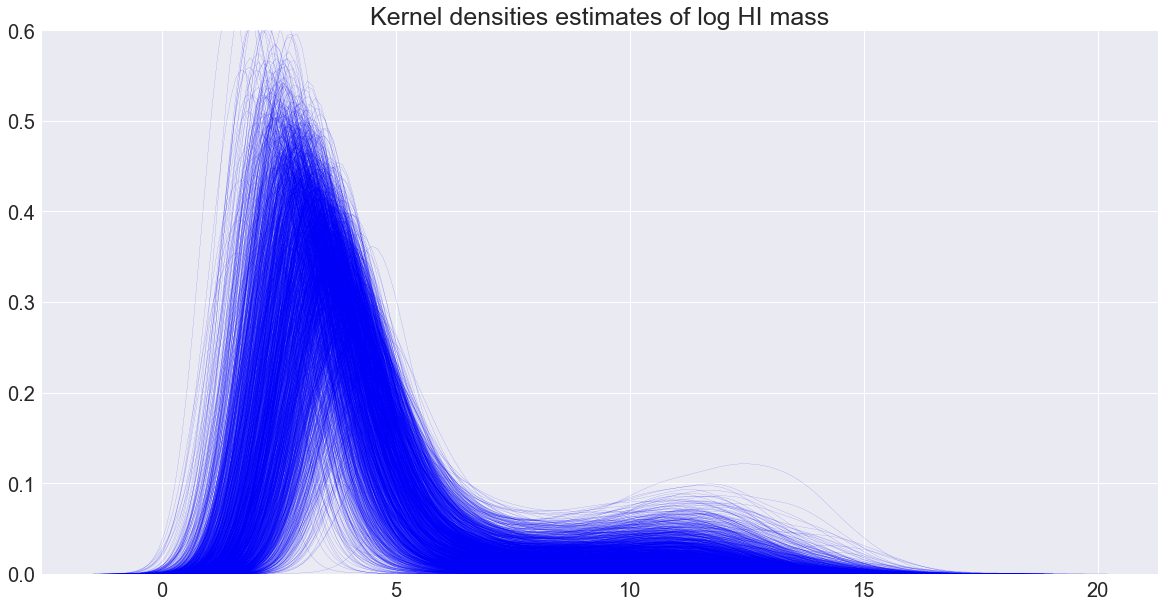

In [9]:
plot_densities(2000, log_=True)

In [ ]:
def hist_plot_2(real, log_plot) :
    """
    Args:
        real(): real data
        epoch(integer): epoch number
        file_name(string): name of the file
        hd (integer) : if 0 it's a histogram, if 1 it's a pdf
        
    """
    
    plt.figure(figsize = (15,10))
    #plot_min = min(float(noise.min()), float(real.min()))
    #plot_max = max(float(noise.max()), float(real.max()))
    plt.xlim(0.01, .4)
    plt.ylim(0, 10)
    
    bins = np.linspace(0, 0.4, 400)
    
    
    for m in range(noise.shape[0]):
        
        if m==0:
            plt.hist(real[m][0].flatten(), bins = bins, color = "b" , log = log_plot, alpha = 0.3, 
                     normed=True, label='Real')
            plt.hist(noise[m][0].flatten(), bins = bins, color = "r" , log = log_plot, alpha= 0.3, 
                     normed=True, label='Generated')
        else:
            plt.hist(real[m][0].flatten(), bins = bins, color = "b" , log = log_plot, alpha = 0.1, 
                     normed=True)
            plt.hist(noise[m][0].flatten(), bins = bins, color = "r" , log = log_plot, alpha= 0.1, 
                     normed=True)
            
    #plt.savefig(redshift_fig_folder + file_name, bbox_inches='tight')   
    plt.tick_params(axis='both', labelsize=28)
    plt.title('Densities of Real and Generated Samples', fontsize=28)
    plt.legend(fontsize=28)
    plt.show()